<a id="section_ID"></a>

# Superconducting Transition Temperature Prediction from Chemical Formula and Element Properties

The data used in this project is taken from __[K. Hamidieh, Computational Materials Science 154 (2018) 346–354](https://www.sciencedirect.com/science/article/abs/pii/S0927025618304877)__. Hamidieh predicts the superconducting critical temperature based on the features extracted from the superconductor’s chemical formula. His __XGBoost__ model gives out-of-sample
predictions:±__9.5 K based on root-mean-squared-error (rmse)__.

In this notebook, the following models are used to predict the superconducting transition temperature $T_c$ (y) from various elemental properties (X).
- [OLS](#ols)
- [Lasso](#lasso)
- [Ridge](#ridge)
- [XGBoost](#xgbtree)
    - [PCA](#pca)
    - [Select k best](#selectkbest)
    - [Recursive feature elimination](#rfe)

***

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SelectFromModel, SequentialFeatureSelector, f_regression, mutual_info_regression
from sklearn import __version__ as sklearn_version
import datetime
import xgboost as xgb
import sys
from joblib import dump

# Import data and split train-test

In [2]:
#import the cleaned data
data = pd.read_csv('../data/processed/data_cleaned.csv')

In [3]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

***

# OLS<a id='ols'><a>

Try the most simple model.

Since ranges of each feature are on different scale, use StandardScaler first. 

In [235]:
steps = [('scaler', StandardScaler()), ('ols', LinearRegression())]
pipeline_ols = Pipeline(steps)
ols_score = cross_val_score(pipeline_ols, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)

In [236]:
-ols_score.mean(), ols_score.std()

(17.601118480113513, 0.34217997583595056)

## Select k best

A lot of features are from the same features, try selecting feature to improve the model.

In [9]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('ols', LinearRegression())]
pipeline_ols_k = Pipeline(steps)
k = [k for k in range(1,X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
ols_k_cv = GridSearchCV(pipeline_ols_k, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
ols_k_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('ols', LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

In [10]:
ols_k_cv.best_params_, -ols_k_cv.best_score_

({'selectkbest__k': 81}, 17.601118480113513)

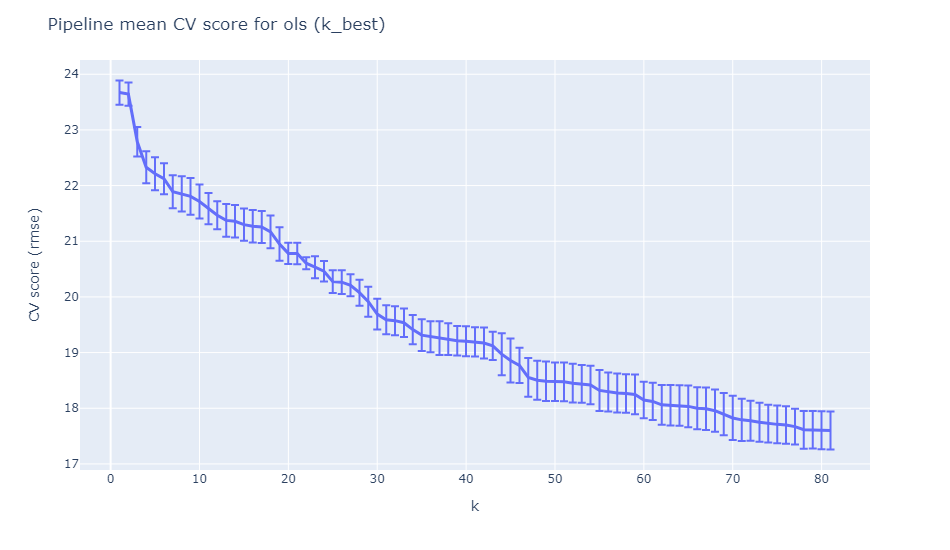

In [237]:
score_mean = -ols_k_cv.cv_results_['mean_test_score']
score_std = ols_k_cv.cv_results_['std_test_score']
fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score for ols (k_best)',
                  yaxis_title='CV score (rmse)',xaxis_title='k', width=950, height=550)
fig.show('png')

The best k is 81 and the score keep decreasing with increasing k.

## Coefficients

Check coefficients of the ols.

In [12]:
coef = ols_k_cv.best_estimator_.named_steps.ols.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_ols = coef_df.nlargest(10, 'coefficient')
topten_ols

,feature,coefficient
22,wtd_mean_atomic_radius,91.021947
72,wtd_mean_Valence,33.719440
75,entropy_Valence,29.304128
49,std_ElectronAffinity,26.442875
14,wtd_gmean_fie,25.381237
25,entropy_atomic_radius,25.255210
73,gmean_Valence,24.815887
1,mean_atomic_mass,24.713880
62,wtd_mean_ThermalConductivity,22.922783
4,wtd_gmean_atomic_mass,22.669077


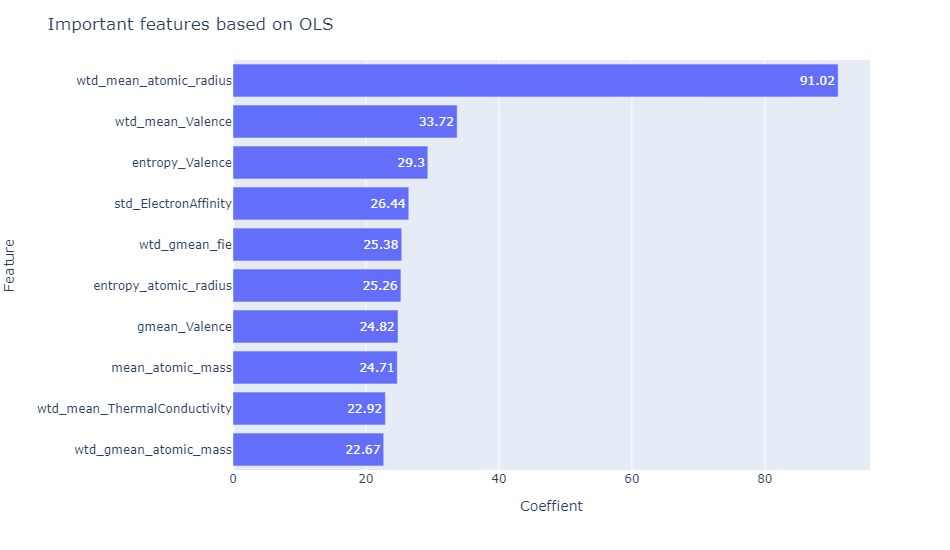

In [238]:
fig = px.bar(x=topten_ols.coefficient[::-1], y=topten_ols.feature[::-1], text_auto='.4', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on OLS',yaxis_title='Feature',
                  xaxis_title='Coeffient')
fig.show('png')

The most important feature is __weighted mean atomic radius__.

## Result

Best model of ols is just the base model.

In [14]:
y_pred = ols_k_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


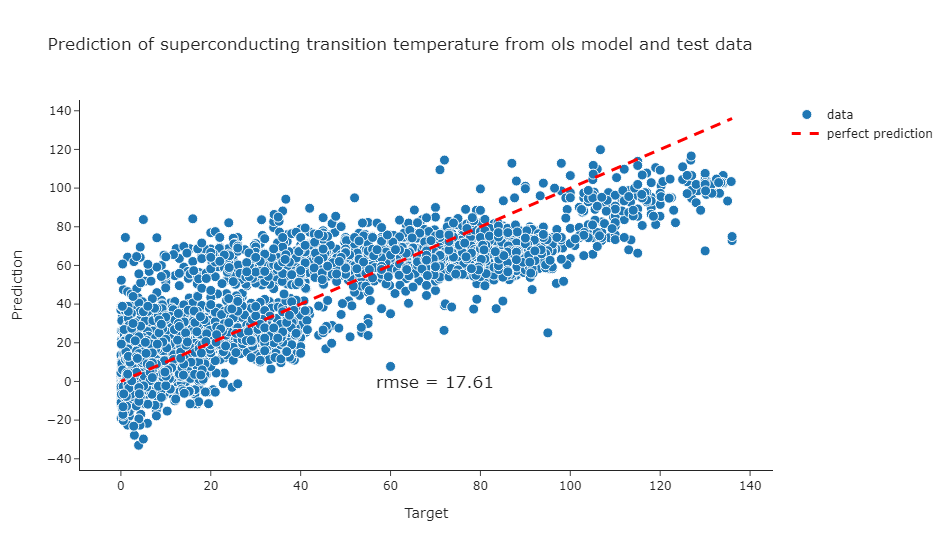

In [262]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', marker=dict(size=10,line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', 
                  title='Prediction of superconducting transition temperature from ols model and test data',
                  yaxis_title='Prediction',xaxis_title='Target', showlegend=True, width=950, height=550)
fig.show('png')

***

# Lasso<a id='lasso'><a>

Use lasso for feature selection.

Do GridSearchCV with alpha in Lasso.

In [207]:
steps = [('scaler', StandardScaler()), ('lasso', Lasso(max_iter=100000))]
# increase max_iter to avoid divergence
pipeline_lasso = Pipeline(steps)
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
parameters = {'lasso__alpha':alpha}
lasso_cv = GridSearchCV(pipeline_lasso, param_grid=parameters, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=100000))]),
             param_grid={'lasso__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                          10]},
             scoring='neg_root_mean_squared_error')

In [208]:
lasso_cv.best_params_, -lasso_cv.best_score_

({'lasso__alpha': 0.0001}, 17.590319286121417)

Similar result with ols.

Check if any coefficients are 0.

In [266]:
(lasso_cv.best_estimator_.named_steps.lasso.coef_==0).any()

False

None.

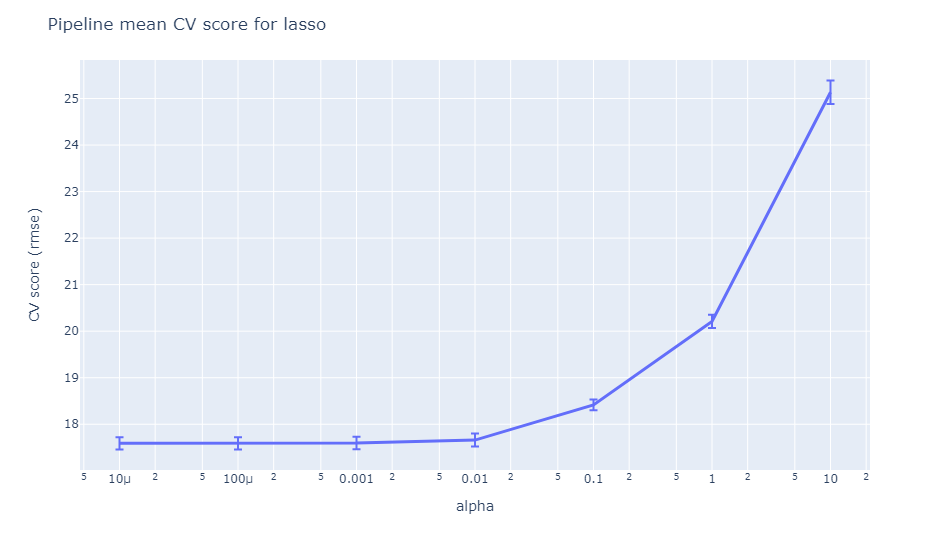

In [259]:
result = pd.DataFrame({'alpha':lasso_cv.cv_results_['param_lasso__alpha'], 
                       'mean':-lasso_cv.cv_results_['mean_test_score'], 'std':lasso_cv.cv_results_['std_test_score']})
fig = px.line(result, x='alpha', y='mean', error_y='std', log_x=True)
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score for lasso',yaxis_title='CV score (rmse)',
                  xaxis_title='alpha', width=950, height=550)
fig.show('png')

## Coefficients

Check coefficients

In [210]:
coef = lasso_cv.best_estimator_.named_steps.lasso.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_lasso = coef_df.nlargest(10, 'coefficient')
topten_lasso

,feature,coefficient
22,wtd_mean_atomic_radius,89.176098
72,wtd_mean_Valence,31.983121
75,entropy_Valence,29.007747
49,std_ElectronAffinity,26.465963
1,mean_atomic_mass,24.351358
25,entropy_atomic_radius,23.978465
73,gmean_Valence,23.726517
62,wtd_mean_ThermalConductivity,22.952193
14,wtd_gmean_fie,22.945166
4,wtd_gmean_atomic_mass,22.136501


The most important feature is __weighted mean atomic radius__.

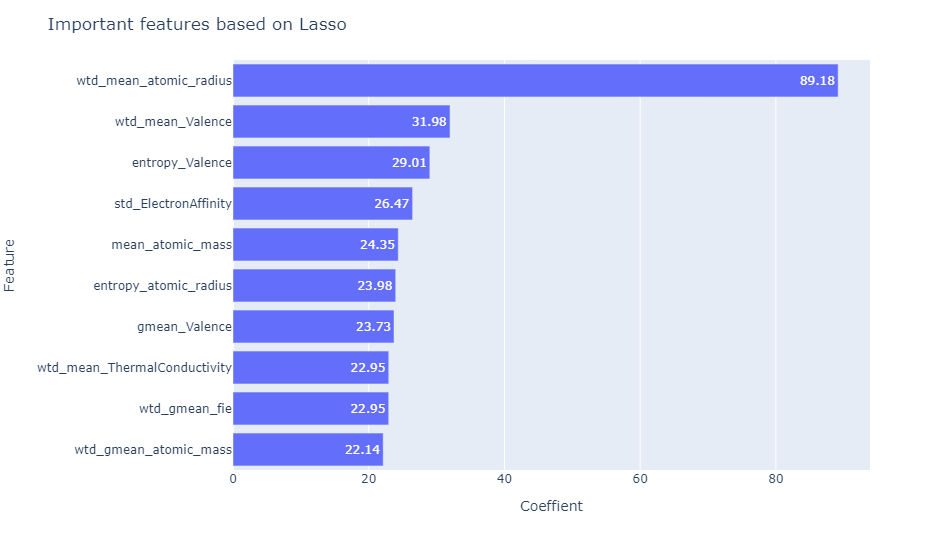

In [269]:
fig = px.bar(x=topten_lasso.coefficient[::-1], y=topten_lasso.feature[::-1], text_auto='.4', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on Lasso',yaxis_title='Feature',
                  xaxis_title='Coeffient')
fig.show('png')

## Result

The best model of lasso is 'lasso__alpha': 0.0001.

In [315]:
y_pred = lasso_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


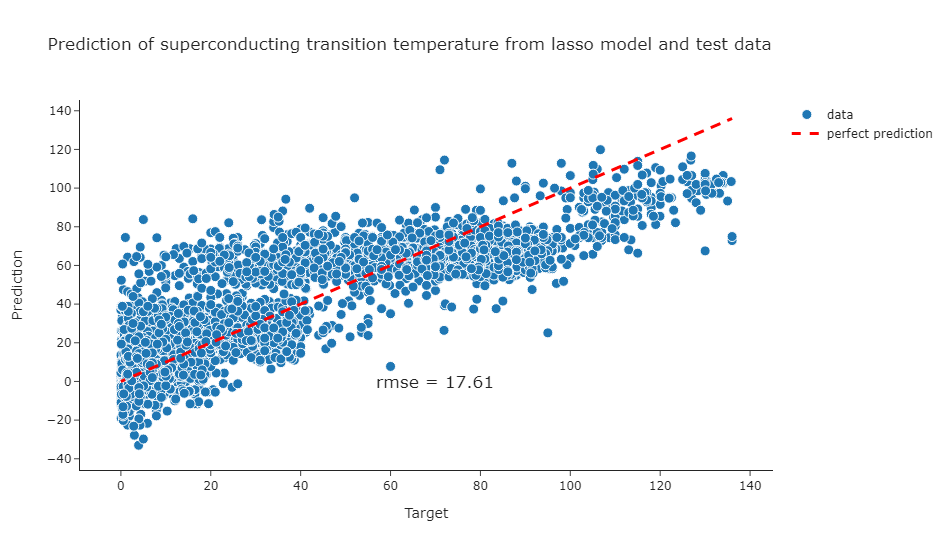

In [316]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10, line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', 
                  title='Prediction of superconducting transition temperature from lasso model and test data',
                  yaxis_title='Prediction',xaxis_title='Target', showlegend=True, width=950, height=550)
fig.show('png')

***

# Ridge<a id='ridge'><a>

Try select feature with ridge regularization.

## Select k best

In [140]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('ridge', Ridge())]
pipeline = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
parameters = {'selectkbest__k':k, 'ridge__alpha':alpha}
ridge_k_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
ridge_k_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                          10],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

In [141]:
ridge_k_cv.best_params_, -ridge_k_cv.best_score_

({'ridge__alpha': 0.1, 'selectkbest__k': 81}, 17.600926724512263)

Similar to ols.

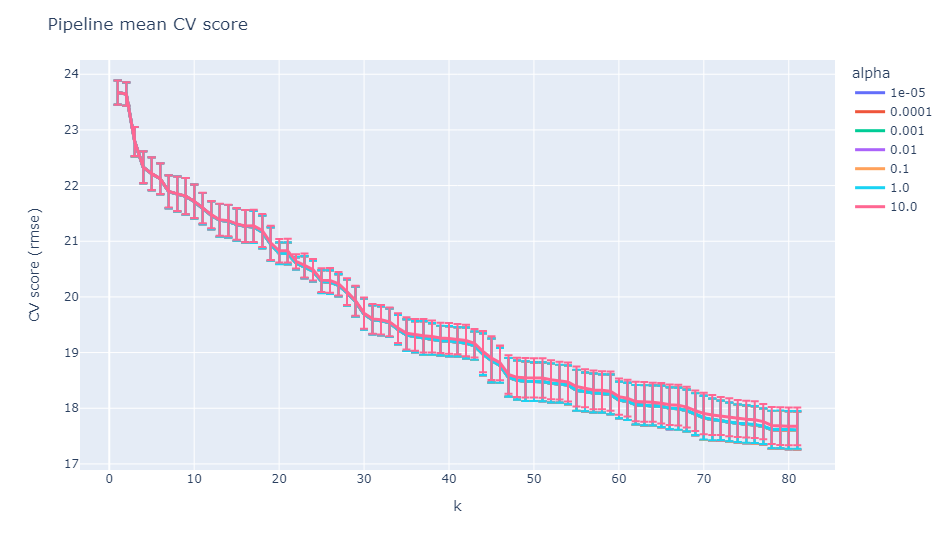

In [267]:
result = pd.DataFrame({'alpha':ridge_k_cv.cv_results_['param_ridge__alpha'], 'k':ridge_k_cv.cv_results_['param_selectkbest__k'],
                       'mean':-ridge_k_cv.cv_results_['mean_test_score'], 'std':ridge_k_cv.cv_results_['std_test_score']})
fig = px.line(result, x='k', y='mean', error_y='std', color='alpha')
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score',yaxis_title='CV score (rmse)',
                  xaxis_title='k', width=950, height=550)
fig.show('png')

## Coefficients

Check coefficient

In [143]:
coef = ridge_k_cv.best_estimator_.named_steps.ridge.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_ridge = coef_df.nlargest(10, 'coefficient')
topten_ridge

,feature,coefficient
22,wtd_mean_atomic_radius,86.035328
72,wtd_mean_Valence,31.039135
75,entropy_Valence,28.595790
49,std_ElectronAffinity,26.540539
1,mean_atomic_mass,24.149887
73,gmean_Valence,23.234235
62,wtd_mean_ThermalConductivity,22.939979
25,entropy_atomic_radius,22.692273
17,range_fie,21.789091
4,wtd_gmean_atomic_mass,21.729281


The most important feature is __weighted mean atomic radius__.

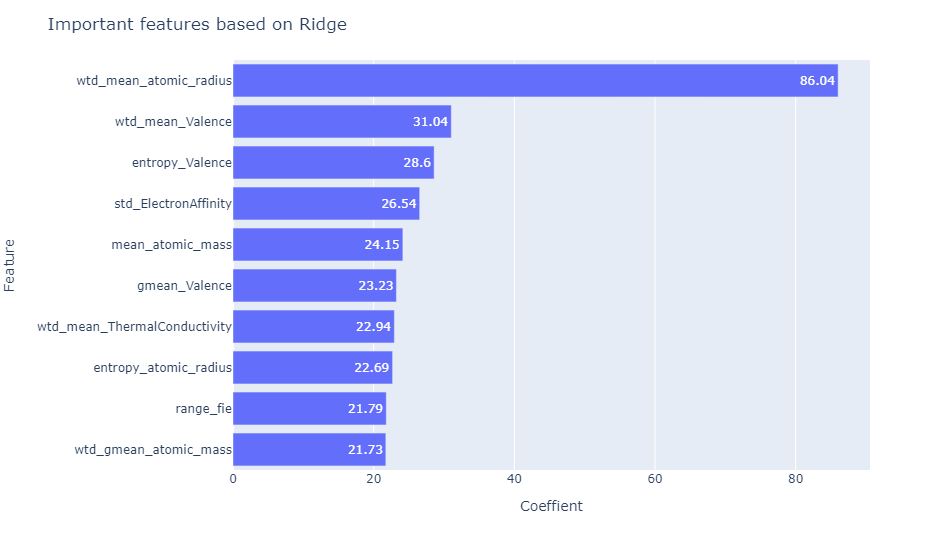

In [271]:
fig = px.bar(x=topten_ridge.coefficient[::-1], y=topten_ridge.feature[::-1], text_auto='.4')
fig.update_layout(template = 'plotly', title='Important features based on Ridge',yaxis_title='Feature',
                  xaxis_title='Coeffient', width=950, height=550)
fig.show('png')

## Result

The best model of ride is 'ridge__alpha': 0.1, 'selectkbest__k': 81.

In [318]:
y_pred = ridge_k_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


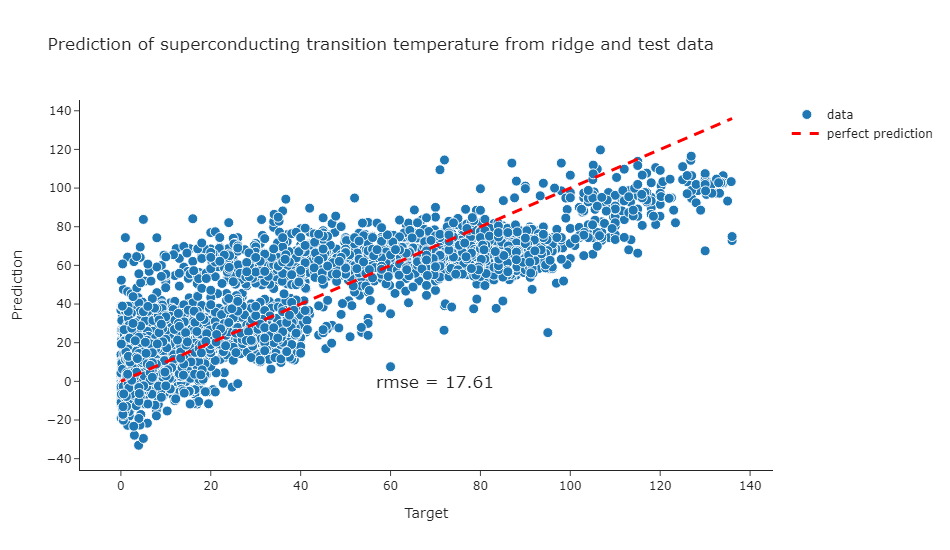

In [319]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10, line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', 
                  title='Prediction of superconducting transition temperature from ridge and test data',
                  yaxis_title='Prediction',xaxis_title='Target', showlegend=True, width=950, height=550)
fig.show('png')

***

# XGBoost<a id='xgbtree'><a>

Since there are many hyperparameters, use __BayesianOptimization__.

Define optimatiation function with mean of cross_val_score

In [136]:
def generate_xgb_eval(X_train, y_train):
    def xgb_eval(n_estimators:int, max_depth:int, learning_rate:float, gamma:float, reg_alpha:float, reg_lambda:float, 
             subsample:float, colsample_bytree:float)->float:
        # n_estimators and max_depth has to be int.
        xgb_param_grid = {'objective':'reg:squarederror', 'n_estimators':int(n_estimators), 'max_depth':int(max_depth),
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                     'subsample':subsample, 'colsample_bytree':colsample_bytree}
        xgb_reg = xgb.XGBRegressor(**xgb_param_grid)
        score = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
        return score.mean()
    return xgb_eval

Searching space

In [137]:
xgb_param_grid = {'n_estimators':(100,300.99), 'max_depth':(1,20.99),
                      'learning_rate':(0.01,1), 'gamma':(0.0 ,1.0), 'reg_alpha':(0.0,1.0), 'reg_lambda':(0.0,1.0),
                     'subsample':(0.01, 1.0), 'colsample_bytree':(0.01, 1.0)}

In [138]:
xgb_eval = generate_xgb_eval(X_train, y_train)
xgb_opt = BayesianOptimization(xgb_eval, xgb_param_grid, random_state=0)
xgb_opt.maximize(n_iter=20, init_points=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -11.48    | 0.5533    | 0.7152    | 0.6067    | 11.89     | 185.2     | 0.6459    | 0.4376    | 0.8929    |
| 2         | -8.805e+0 | 0.964     | 0.3834    | 0.7938    | 11.57     | 214.2     | 0.9256    | 0.07104   | 0.09626   |
| 3         | -18.07    | 0.03002   | 0.8326    | 0.7804    | 18.39     | 296.7     | 0.7992    | 0.4615    | 0.7827    |
| 4         | -10.19    | 0.1271    | 0.6399    | 0.1519    | 19.88     | 204.9     | 0.4147    | 0.2646    | 0.7765    |
| 5         | -9.491    | 0.4616    | 0.5684    | 0.0286    | 13.35     | 223.0     | 0.6169    | 0.9437    | 0.685     |
| 6         | -29.87    | 0.6182    | 0.8174    | 0.7124    | 15.93     | 256.0     | 0.7037    | 0.1164    | 0.3405    |
| 7         | -12.35    

Best hyperparameters and result

In [139]:
xgb_opt.max

{'target': -9.490946931958375,
 'params': {'colsample_bytree': 0.4615888288943831,
  'gamma': 0.5684339488686485,
  'learning_rate': 0.028601902431991594,
  'max_depth': 13.346533586546782,
  'n_estimators': 223.0251193099795,
  'reg_alpha': 0.6169339968747569,
  'reg_lambda': 0.9437480785146242,
  'subsample': 0.6850020961124486}}

The score is a lot better than the linear models.

In [75]:
params = xgb_opt.max['params']
#change n_estimators and max_depth to int
params['n_estimators'] = int(params['n_estimators'])
params['max_depth'] = int(params['max_depth'])

***

## PCA<a id='pca'><a>

Since all 81 features come from only 8 properties, there are high correlations between features.

Do PCA to reduce dimensions.

In [200]:
steps = [('scaler', StandardScaler()), ('pca', PCA())]
pipeline_pca = Pipeline(steps)
pipeline_pca.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

Check explained variance ratio.

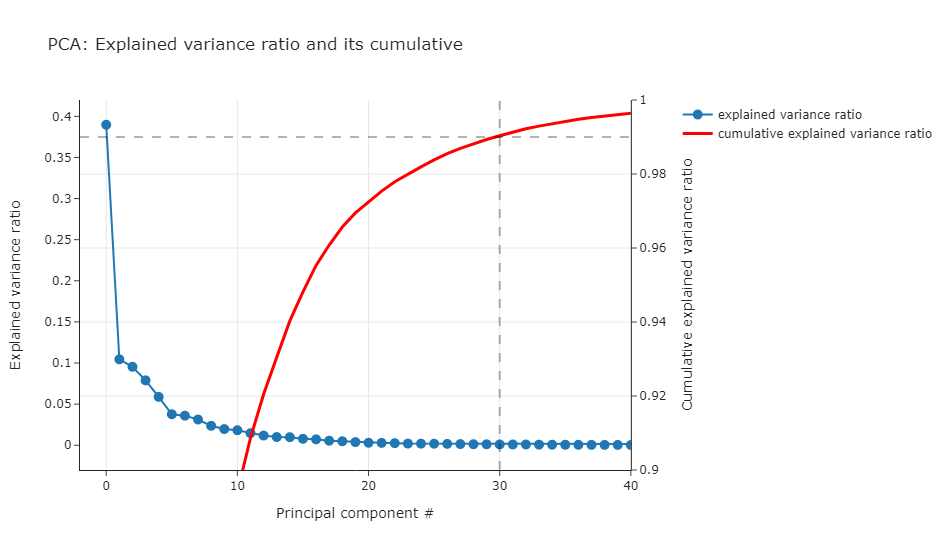

In [283]:
exp_var_ratio = pipeline_pca.named_steps.pca.explained_variance_ratio_
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio, name='explained variance ratio',
                         mode='lines+markers', marker=dict(size=10)), secondary_y=False)
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio.cumsum(), 
                         name='cumulative explained variance ratio',
                         mode='lines', line=dict(color='red', width=3)), secondary_y=True)

fig.add_vline(x=30, line_width=2, line_dash="dash")
fig.add_hline(y=0.99, line_width=2, line_dash="dash", secondary_y=True)

fig.update_xaxes(range=[-2, 40],showgrid=True)

fig.update_yaxes(title_text="Explained variance ratio", showgrid=False,secondary_y=False)
fig.update_yaxes(title_text="Cumulative explained variance ratio", showgrid=True, range=[0.9,1],secondary_y=True)

fig.update_layout(template = 'simple_white', title='PCA: Explained variance ratio and its cumulative',
                  xaxis_title='Principal component #', showlegend=True, width=950, height=550)
fig.show('png')

Cumulative explained variance of 0.99 are at PC30. 

$\therefore$ Try n_components = 31.

In [203]:
steps = [('scaler', StandardScaler()), ('pca', PCA(31, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_pca = Pipeline(steps)
xgb_pca_score = cross_val_score(pipeline_xgb_pca, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)

In [204]:
-xgb_pca_score.mean(), xgb_pca_score.std()

(10.296865561579962, 0.3880784344178253)

However using PCA makes it difficult to indicate which features and properties are important in predicting $T_c$.

***

## Select k best<a id='selectkbest'><a>

Try select k best feature with __f_regression__ using the hyperparameters from above.

In [156]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
xgb_f_cv = GridSearchCV(pipeline_xgb_f, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
xgb_f_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.4615888288943831,
                                                     early_...
                                                     max_delta_step=None,
                                                     max_depth=13,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=223,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

check best score

In [157]:
xgb_f_cv.best_params_, -xgb_f_cv.best_score_

({'selectkbest__k': 80}, 9.491470375408579)

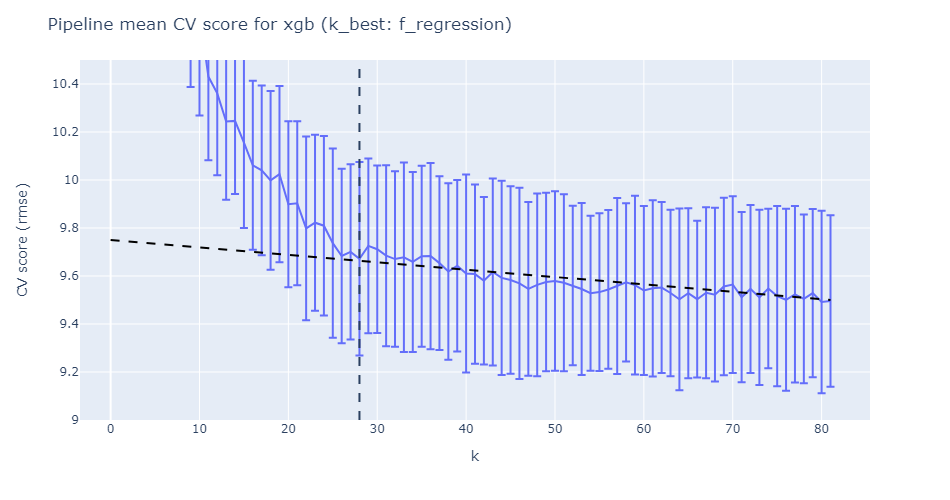

In [302]:
score_mean = -xgb_f_cv.cv_results_['mean_test_score']
score_std = xgb_f_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.75,9.5], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))

fig.add_vline(x=28, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (k_best: f_regression)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('png')

Score is stable around 28. More features have diminishing return and may lead to overfit.

In [162]:
-xgb_f_cv.cv_results_['mean_test_score'][27]

9.671690827649886

Refit at k=28.

In [163]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression, k=28)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f_28 = Pipeline(steps)
pipeline_xgb_f_28.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=28,
                             score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4615888288943831,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.028601902431991594, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=13,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=223, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

## Importance features

In [351]:
importances = pipeline_xgb_f_28.named_steps.xgb.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[pipeline_xgb_f_28.named_steps.selectkbest.get_support()], 
                              'importance': importances})
topten_xgb_f = importance_df.nlargest(10, 'importance')
topten_xgb_f

,feature,importance
18,range_ThermalConductivity,0.547673
10,range_atomic_radius,0.111756
27,wtd_entropy_Valence,0.044628
21,wtd_std_ThermalConductivity,0.043930
20,std_ThermalConductivity,0.029754
23,wtd_mean_Valence,0.024931
24,gmean_Valence,0.022709
25,wtd_gmean_Valence,0.022345
19,wtd_range_ThermalConductivity,0.016151
15,entropy_Density,0.013931


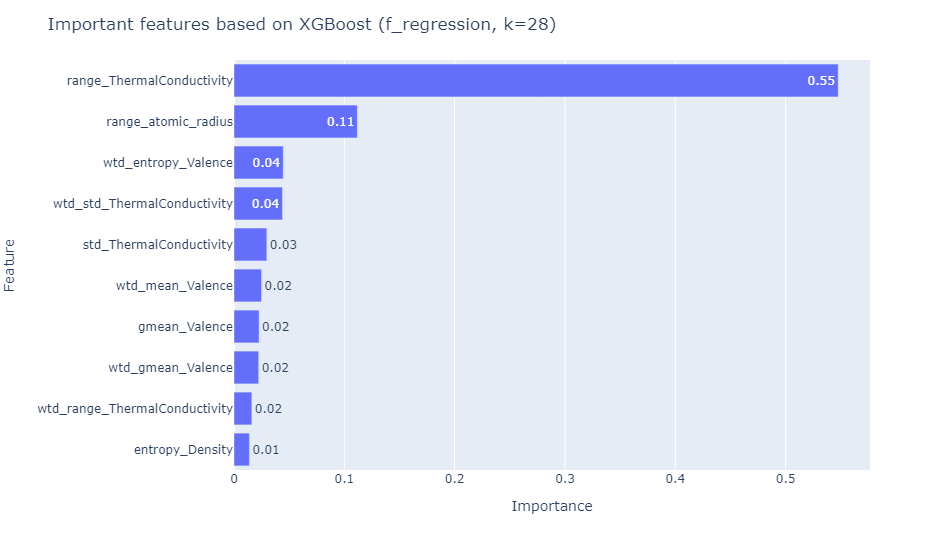

In [284]:
fig = px.bar(x=topten_xgb_f.importance[::-1], y=topten_xgb_f.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (f_regression, k=28)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

***

Try select k best feature with __mutual_info_regression__, since F-test captures only linear dependency, but mutual information can capture any kind of dependency between variables.

In [166]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(mutual_info_regression)), ('xgb', xgb.XGBRegressor(**params))]
pipeline = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
xgb_mi_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
xgb_mi_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x0000019E3A8D5080>)),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.4615888288943...
                                                     max_delta_step=None,
                                                     max_depth=13,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=223,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

check best score

In [167]:
xgb_mi_cv.best_params_, -xgb_mi_cv.best_score_

({'selectkbest__k': 67}, 9.458443245542096)

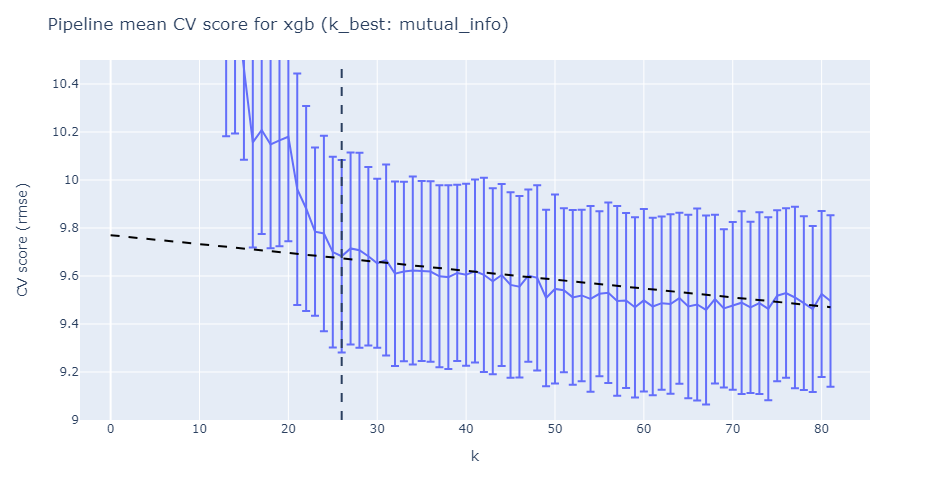

In [303]:
score_mean = -xgb_mi_cv.cv_results_['mean_test_score']
score_std = xgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.77,9.47], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))
fig.add_vline(x=26, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (k_best: mutual_info)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('png')

Score plateaus around 26. More features have diminishing return and may lead to overfit.

In [185]:
-xgb_mi_cv.cv_results_['mean_test_score'][25]

9.682272232141294

Refit at k=26.

In [186]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression, k=26)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_mi_26 = Pipeline(steps)
pipeline_xgb_mi_26.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=26,
                             score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4615888288943831,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.028601902431991594, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=13,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=223, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

## Important features

In [354]:
importances = pipeline_xgb_mi_26.named_steps.xgb.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[pipeline_xgb_mi_26.named_steps.selectkbest.get_support()], 
                              'importance': importances})
topten_xgb_mi_26 = importance_df.nlargest(10, 'importance')
topten_xgb_mi_26

,feature,importance
17,range_ThermalConductivity,0.436439
10,range_atomic_radius,0.133103
18,std_ThermalConductivity,0.082337
19,wtd_std_ThermalConductivity,0.063447
25,wtd_entropy_Valence,0.040877
24,entropy_Valence,0.031520
22,gmean_Valence,0.031337
23,wtd_gmean_Valence,0.024594
21,wtd_mean_Valence,0.021080
15,entropy_FusionHeat,0.014707


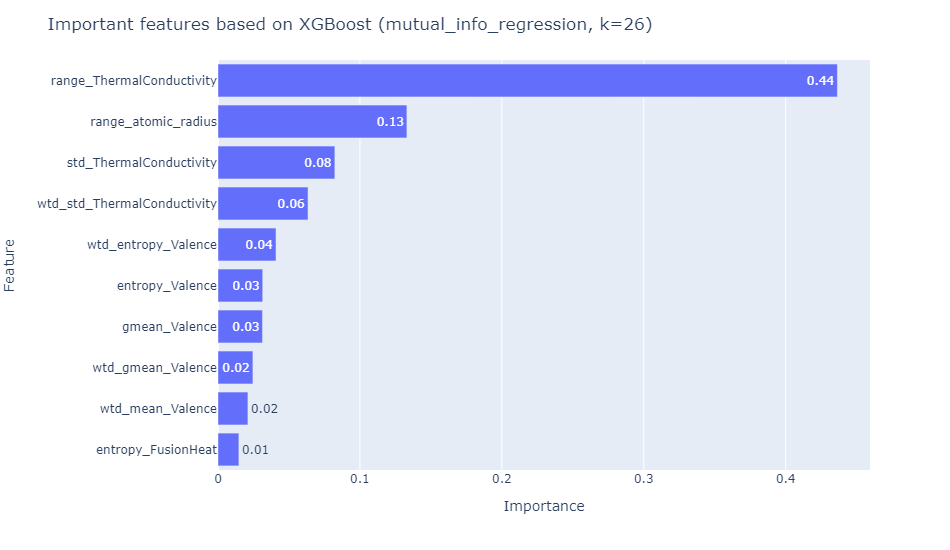

In [287]:
fig = px.bar(x=topten_xgb_mi_26.importance[::-1], y=topten_xgb_mi_26.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (mutual_info_regression, k=26)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

***

## Recursive feature elimination<a id='rfe'><a>

Features with high MI might be redundant with other selected features, leading to unnecessary complexity and potentially hindering model performance. Thus, try selecting feature based on feature importance from XGBoost itself.

In [76]:
xgb_rfecv1 = RFECV(xgb.XGBRegressor(**params), scoring='neg_root_mean_squared_error', cv=kf)
xgb_rfecv1.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=0.4615888288943831,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=0.5684339488686485,
                             gpu_id=None, grow_policy=None,
                             impor...n_constraints=None,
                             learning_rate=0.028601902431991594, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=13, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=223,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, ...),
      scoring='neg_root_mean_squared_error')

In [323]:
xgb_rfecv1.n_features_, -xgb_rfecv1.cv_results_['mean_test_score'].max()

(74, 9.457690261953857)

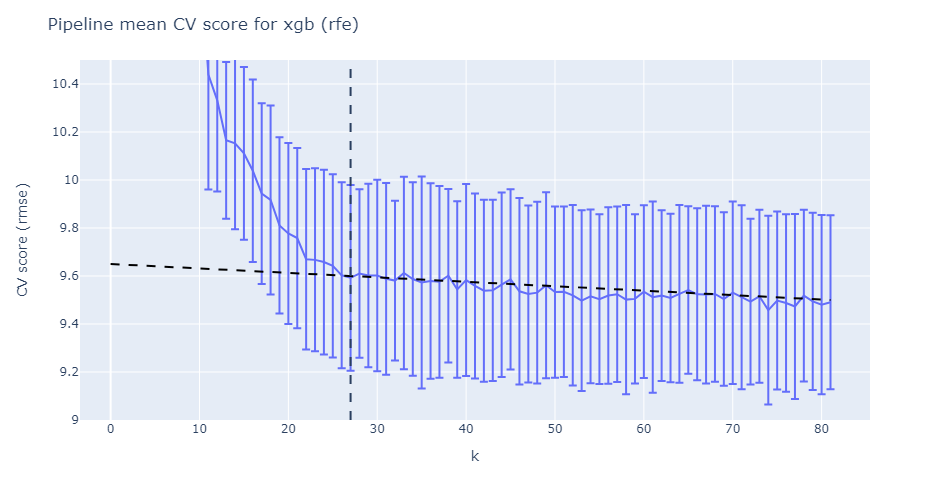

In [304]:
score_mean = -xgb_rfecv1.cv_results_['mean_test_score']
score_std = xgb_rfecv1.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.65,9.5], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))
fig.add_vline(x=27, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (rfe)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('png')

Score and derivative are stable around k=27.

In [104]:
-xgb_rfecv1.cv_results_['mean_test_score'][26]

9.592545052526601

Refit at k=27.

In [101]:
xgb_rfe = RFE(xgb.XGBRegressor(**params), n_features_to_select=27)
xgb_rfe.fit(X_train, y_train)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=0.4615888288943831,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None,
                           gamma=0.5684339488686485, gpu_id=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None,
                           learning_rate=0.028601902431991594, max_bin=None,
                           max_cat_threshold=None, max_cat_to_onehot=None,
                           max_delta_step=None, max_depth=13, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=223,
                           n_jobs=None, num_parallel_tree=None, predictor=None,
                           random_state=None, ...),
    n_features_to_select=27)

## Importance features

In [356]:
importances = xgb_rfe.estimator_.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[xgb_rfe.support_], 
                              'importance': importances})
topten_xgb_rfe = importance_df.nlargest(10, 'importance')
topten_xgb_rfe

,feature,importance
15,range_ThermalConductivity,0.688787
2,range_atomic_radius,0.043060
24,wtd_entropy_Valence,0.024890
23,entropy_Valence,0.022351
18,wtd_std_ThermalConductivity,0.019539
21,gmean_Valence,0.015047
22,wtd_gmean_Valence,0.014334
17,std_ThermalConductivity,0.013354
16,wtd_range_ThermalConductivity,0.012603
13,wtd_gmean_ThermalConductivity,0.010889


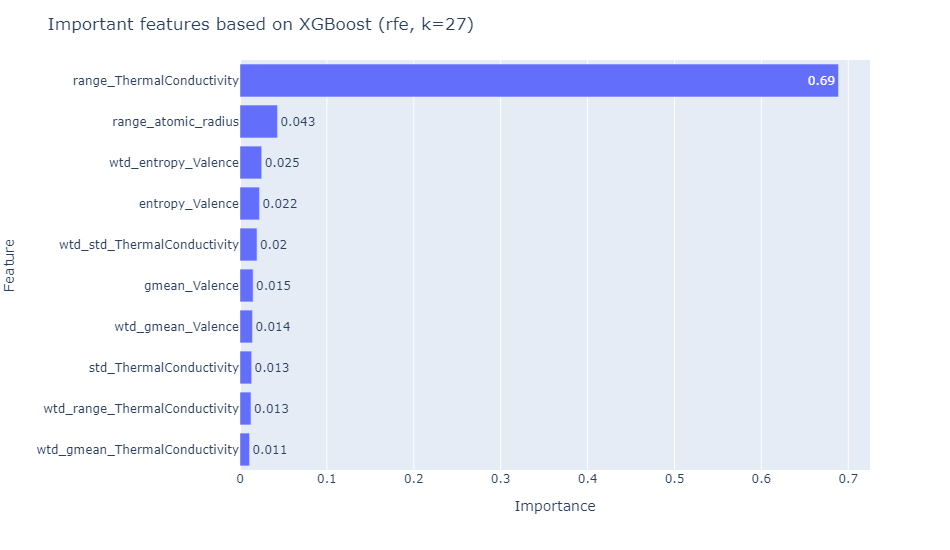

In [332]:
fig = px.bar(x=topten_xgb_rfe.importance[::-1], y=topten_xgb_rfe.feature[::-1], text_auto='.2', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (rfe, k=27)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

***

## Result

Best model of XGBoost is rfe, k=27 and hyperparameters:
- 'colsample_bytree': 0.4615888288943831
- 'gamma': 0.5684339488686485
- 'learning_rate': 0.02860190243199159
- 'max_depth': 13.346533586546782
- 'n_estimators': 223.0251193099795
- 'reg_alpha': 0.6169339968747569
- 'reg_lambda': 0.9437480785146242
- 'subsample': 0.6850020961124486

In [358]:
y_pred = xgb_rfe.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 9.49, r2: 0.92


Slightly better compared to previous work (K. Hamidieh, Computational Materials Science 154 (2018) 346–354).

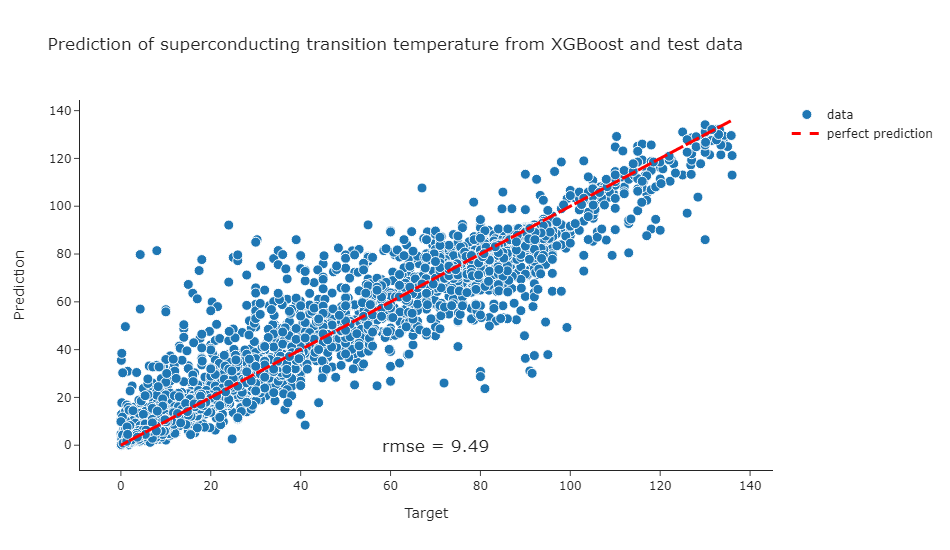

In [336]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10,line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', 
                  title='Prediction of superconducting transition temperature from XGBoost and test data',
                  yaxis_title='Prediction', xaxis_title='Target', showlegend=True, width=950, height=550)
fig.show('png')

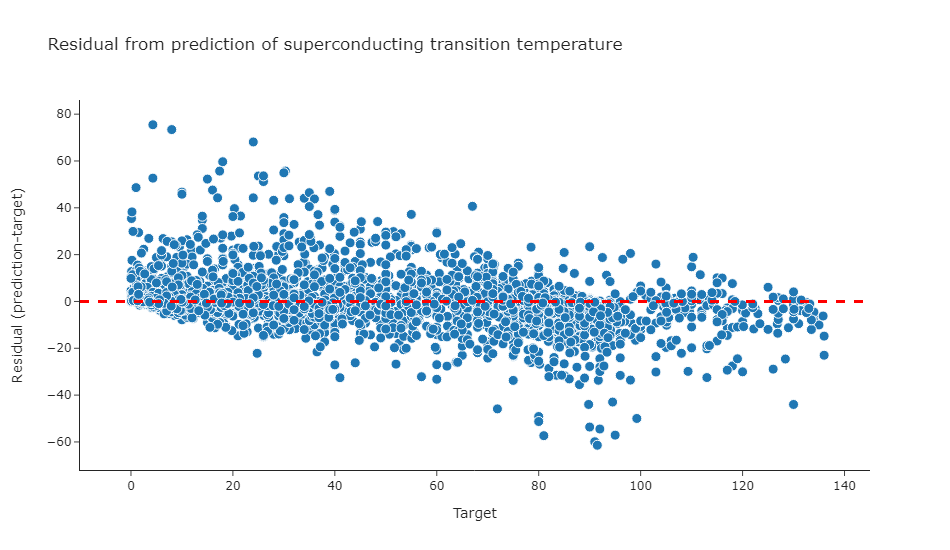

In [372]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred-y_test,mode='markers', 
                         marker=dict(size=10,line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=[-10,145], y=[0,0],mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.update_layout(template = 'simple_white', 
                  title='Residual from prediction of superconducting transition temperature',
                  yaxis_title='Residual (prediction-target)', xaxis_title='Target', showlegend=False, width=950, height=550)
fig.show('png')

At low temperaute the prediction is too high while the prediction is too low in high temperature region.

***

# Learning curve

Check if more data will improve the model.

In [227]:
fractions = [0.1, 0.33, 0.55, 0.78, 1.]
train_size, train_scores, test_scores = learning_curve(xgb_rfe, X_train, y_train, train_sizes=fractions, 
                                                       scoring='neg_root_mean_squared_error', cv=kf)

In [228]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

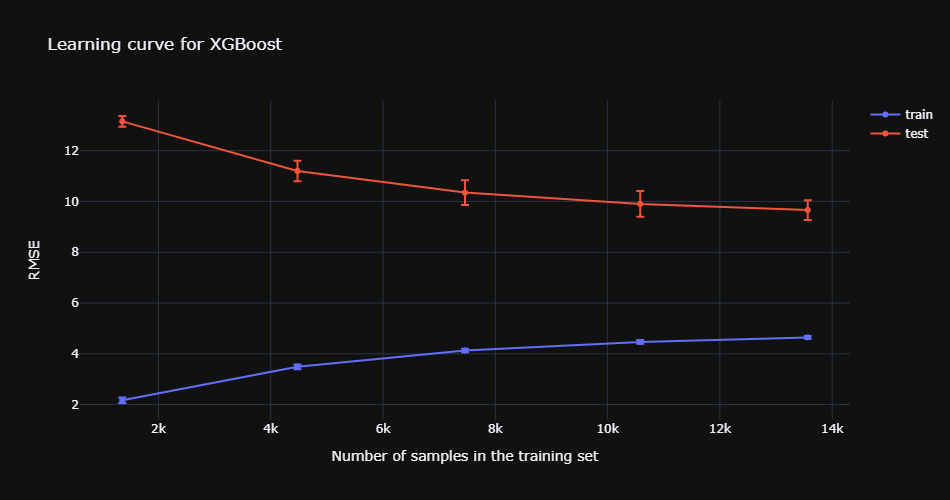

In [327]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_size, y=-train_scores_mean, name='train',
                         error_y=dict(type='data', array=train_scores_std,visible=True)))
fig.add_trace(go.Scatter(x=train_size, y=-test_scores_mean, name='test',
                         error_y=dict(type='data', array=test_scores_std,visible=True)))
fig.update_xaxes(title='Number of samples in the training set')
fig.update_yaxes(title='RMSE')
fig.update_layout(title='Learning curve for XGBoost', template='plotly_dark', width=950, height=500)
fig.show('png')

The test score increases with the size of the training dataset to a point where it reaches a plateau. It might not be useful to acquire new data to train the model. 

***

# Save best model

In [215]:
xgb_rfe_model = xgb_rfe
xgb_rfe_model.version = '1.0'
xgb_rfe_model.python_version = sys.version
xgb_rfe_model.pandas_version = pd.__version__
xgb_rfe_model.numpy_version = np.__version__
xgb_rfe_model.sklearn_version = sklearn_version
xgb_rfe_model.X_columns = [col for col in X.columns[xgb_rfe.support_]]
xgb_rfe_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
dump(xgb_rfe_model, f'{modelpath}/xgb_rfe_model.joblib')

['../models/xgb_rfe_model.joblib']